## Intro: 

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.

Rusty Bargain is interested in:
    the quality of the prediction,
    the speed of the prediction,
    the time required for training

Use the RMSE metric to evaluate the models.


Data Description:

    Features:
    DateCrawled — date profile was downloaded from the database
    VehicleType — vehicle body type
    RegistrationYear — vehicle registration year
    Gearbox — gearbox type
    Power — power (hp)
    Model — vehicle model
    Mileage — mileage (measured in km due to dataset's regional specifics)
    RegistrationMonth — vehicle registration month
    FuelType — fuel type
    Brand — vehicle brand
    NotRepaired — vehicle repaired or not
    DateCreated — date of profile creation
    NumberOfPictures — number of vehicle pictures
    PostalCode — postal code of profile owner (user)
    LastSeen — date of the last activity of the user
    
    
    Target:
    Price — price (Euro)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing 
#import models
from sklearn.linear_model import LinearRegression
import lightgbm
import sklearn.model_selection 
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import *
from sklearn.model_selection import *
from sklearn.ensemble import *

from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error



In [2]:
try:
    df_car = pd.read_csv('datasets/car_data.csv') #read csv file stored locally on my laptop
except:
    df_car = pd.read_csv('/datasets/car_data.csv') #make an exception for when I upload the project to Practicum


In [3]:
!pip install catboost

In [4]:
df_car.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
len(df_car)

354369

In [6]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

We can see some data types are not correct. For example DateCrawled should be a data and time feature. We ultimately want and need features to be in numerical terms for gradient boosting to work properly so we may need to drop these columns if we can't encode them with something like OHE for example. I won't worry about changing them to type datetime since I will probably drop all date features because of their high cardinality when doing OHE.

In [7]:
df_car.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Registration year has so strange values like year 9999 lets see how many rows have strange very high or very small RegistrationYear.

In [8]:
df_car.query('RegistrationYear>2023')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
12946,29/03/2016 18:39,49,NaN,5000,NaN,0,golf,5000,12,NaN,volkswagen,NaN,29/03/2016 00:00,0,74523,06/04/2016 04:16
15147,14/03/2016 00:52,0,NaN,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,13/03/2016 00:00,0,32689,21/03/2016 23:46
15870,02/04/2016 11:55,1700,NaN,3200,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,02/04/2016 00:00,0,33649,06/04/2016 09:46
17271,23/03/2016 16:43,700,NaN,9999,NaN,0,other,10000,0,NaN,opel,NaN,23/03/2016 00:00,0,21769,05/04/2016 20:16
17346,06/03/2016 16:06,6500,NaN,8888,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,06/03/2016 00:00,0,55262,30/03/2016 20:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334967,20/03/2016 17:53,12000,NaN,4000,NaN,500,golf,5000,0,NaN,volkswagen,no,20/03/2016 00:00,0,57392,07/04/2016 00:46
335727,09/03/2016 07:01,0,NaN,7500,manual,0,other,10000,0,petrol,mini,no,09/03/2016 00:00,0,9669,19/03/2016 19:44
338829,24/03/2016 19:49,50,NaN,3000,NaN,3000,golf,100000,6,NaN,volkswagen,yes,24/03/2016 00:00,0,23992,03/04/2016 13:17
340548,02/04/2016 17:44,0,NaN,3500,manual,75,NaN,5000,3,petrol,sonstige_autos,NaN,02/04/2016 00:00,0,96465,04/04/2016 15:17


In [9]:
df_car.query('RegistrationYear<1900')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
622,16/03/2016 16:55,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,16/03/2016 00:00,0,44628,20/03/2016 16:44
16062,29/03/2016 23:42,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,29/03/2016 00:00,0,47166,06/04/2016 10:44
18224,09/03/2016 17:49,7999,NaN,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,09/03/2016 00:00,0,53577,15/03/2016 05:15
34332,01/04/2016 06:02,450,NaN,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,01/04/2016 00:00,0,63322,01/04/2016 09:42
38875,19/03/2016 23:54,1234,NaN,1234,NaN,26,NaN,5000,1,NaN,trabant,NaN,19/03/2016 00:00,0,38518,06/04/2016 03:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323443,26/03/2016 20:58,30,NaN,1000,NaN,0,NaN,5000,0,NaN,audi,NaN,26/03/2016 00:00,0,37574,06/04/2016 12:17
325739,30/03/2016 11:36,400,NaN,1000,NaN,0,NaN,5000,0,NaN,mercedes_benz,NaN,30/03/2016 00:00,0,8060,01/04/2016 06:16
340759,04/04/2016 23:55,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no,04/04/2016 00:00,0,86343,05/04/2016 06:44
348830,22/03/2016 00:38,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,21/03/2016 00:00,0,41472,05/04/2016 14:18


As we can see above there are very few rows that have RegistrationYear greater than 2023 or less than 1900 so we will drop them since they are so few. 

In [10]:
df_car = df_car.query('RegistrationYear>1900 and RegistrationYear<2023')

In [11]:
df_car.query('RegistrationYear<1900')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


In [12]:
df_car.query('RegistrationYear>2023')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen



Number of pictures seems to always be zero lets double check.

In [13]:
df_car['NumberOfPictures'].sum()

0

In [14]:
#We can safely drop this column since it does not ever change and won't help any models predict price.

In [15]:
df_car.drop(labels=['NumberOfPictures'], axis=1, inplace=True)

In [16]:
df_car.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,60437,06/04/2016 10:17


In [17]:
df_car.isna().sum().sort_values()

DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Mileage                  0
RegistrationMonth        0
Brand                    0
DateCreated              0
PostalCode               0
LastSeen                 0
Model                19630
Gearbox              19695
FuelType             32767
VehicleType          37319
NotRepaired          71007
dtype: int64

In [18]:
df_car_toyota_1 = df_car[df_car['Brand']=='toyota'].pivot_table(values='Price',index='Brand',columns='Model', aggfunc='count')

In [19]:
df_car_toyota_1

Model,auris,avensis,aygo,corolla,other,rav,verso,yaris
Brand,,,,,,,,
toyota,234,565,430,684,844,350,309,1033


We can see that yaris is the most common model followed by other so I wanted to keep the distribution.

In [20]:
df_car['Model'] = df_car.groupby('Brand')['Model'].ffill()

In [21]:
df_car['VehicleType'] = df_car.groupby('Model')['VehicleType'].ffill()

In [22]:
df_car[df_car['Brand']=='toyota'].pivot_table(values='Price',index='Brand',columns='Model', aggfunc='count')


Model,auris,avensis,aygo,corolla,other,rav,verso,yaris
Brand,,,,,,,,
toyota,241,581,450,699,881,364,324,1066


In [23]:
df_car.isna().sum().sort_values()

DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Mileage                  0
RegistrationMonth        0
Brand                    0
DateCreated              0
PostalCode               0
LastSeen                 0
Model                 3342
VehicleType           3381
Gearbox              19695
FuelType             32767
NotRepaired          71007
dtype: int64

In [24]:
df_car['Gearbox'] = df_car.groupby('Model')['Gearbox'].ffill()

In [25]:
df_car.isna().sum().sort_values()

DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Mileage                  0
RegistrationMonth        0
Brand                    0
DateCreated              0
PostalCode               0
LastSeen                 0
Model                 3342
Gearbox               3362
VehicleType           3381
FuelType             32767
NotRepaired          71007
dtype: int64

In [26]:
df_car['FuelType'] = df_car.groupby('Model')['FuelType'].ffill()

In [27]:
df_car.isna().sum().sort_values()

DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Mileage                  0
RegistrationMonth        0
Brand                    0
DateCreated              0
PostalCode               0
LastSeen                 0
Model                 3342
Gearbox               3362
FuelType              3366
VehicleType           3381
NotRepaired          71007
dtype: int64

Now let us look at NotRepaired feature since it has the largest number of NaN values. I can't find a good way to fill this one other than just replacing it with "unknown" to keep all of them as type object. My intuition tells me that the person listing probably omits this answer if they think it will harm the price point of their car. For example a double negative NO - the car is NotRepaired means the car has had a major repair so I wouldn't be surprised if most of these mission values were of value NO. I will just place it an "unknown" since it doesn't add much cardinality for OHE and the models should be able to correctly price it in. 

In [28]:
df_car['NotRepaired'].fillna(value='unknown', inplace=True)

In [29]:
df_car['NotRepaired'].isna().sum()

0

We now can drop the remaining NaN values since they are minimal.

In [30]:
df_car.dropna(inplace=True)

In [31]:
df_car.isna().sum().sort_values()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
PostalCode           0
LastSeen             0
dtype: int64

***NO MORE missing values.***

In [32]:
len(df_car) #We lost very few observations while dealing with missing values and outliers as a percentage.

350795

In [33]:
df_car.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode
count,350795.000000,350795.000000,350795.000000,350795.000000,350795.000000,350795.000000
mean,4411.778882,2003.170450,110.251905,128621.189014,5.730230,50541.830870
std,4503.255934,7.301001,188.775743,37401.495099,3.720952,25764.134087
min,0.000000,1910.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1099.000000,1999.000000,69.000000,125000.000000,3.000000,30169.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49429.000000
75%,6399.000000,2008.000000,143.000000,150000.000000,9.000000,71088.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,99998.000000


Lets look at the amount of unique categories in each categorical feature.

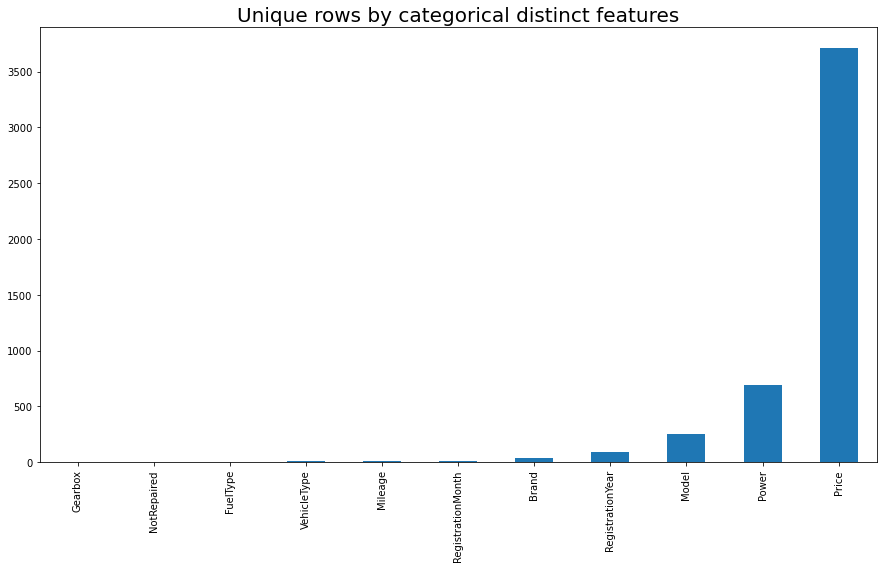

In [101]:
plt.figure(figsize=(15,8))
df_car.nunique().sort_values().plot(kind='bar');
plt.title('Unique rows by categorical distinct features',fontsize=20)
plt.show()

In [35]:
df_car.nunique().sort_values()

Gearbox                  2
NotRepaired              3
FuelType                 7
VehicleType              8
Mileage                 13
RegistrationMonth       13
Brand                   39
RegistrationYear        93
DateCreated            109
Model                  250
Power                  707
Price                 3712
PostalCode            8142
DateCrawled          15454
LastSeen             18544
dtype: int64

First I will drop the dates from the db since they should have no bearing on our target prediction. There are too many different dates in these features to try to encode categorically.  

I am dropping 4 features with high cardinality which should have little if no bearing to the prediction of the target.

In [36]:
df_car.drop(labels=['LastSeen','PostalCode'], axis=1, inplace=True)

In [37]:
df_car.drop(labels=['DateCreated'], axis=1, inplace=True)

In [38]:
df_car.drop(labels='DateCrawled', axis=1, inplace=True)

In [39]:
df_car.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


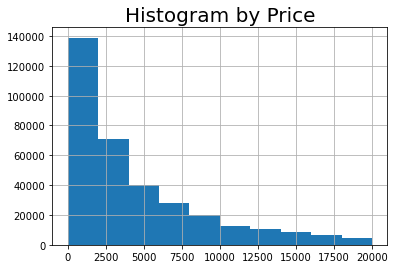

In [102]:
df_car['Price'].hist();
plt.title('Histogram by Price',fontsize=20)
plt.show()

In [41]:
df_car.Price[df_car['Price']==0].count()

10219

In [42]:
df_car = df_car[df_car['Price']>0]

In [43]:
len(df_car) # removing Price of zero since no car should be worth zero otherwise why try to sell it.

340576

***Lets check CatBoostRegressor***

I first just want to see the magic of CatBoostRegressor since it doesn't need to encode categorical features and it can even handle NaN values internally. 

In [44]:
categorical_features = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']

In [45]:
categorical_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [46]:
df_car[categorical_features].isna().sum()

VehicleType    0
Gearbox        0
Model          0
FuelType       0
Brand          0
NotRepaired    0
dtype: int64

In [47]:
df_car[categorical_features]

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
2,suv,auto,grand,gasoline,jeep,unknown
3,small,manual,golf,petrol,volkswagen,no
4,small,manual,fabia,gasoline,skoda,no
5,sedan,manual,3er,petrol,bmw,yes
6,convertible,manual,2_reihe,petrol,peugeot,no
...,...,...,...,...,...,...
354362,sedan,manual,leon,petrol,seat,yes
354363,bus,manual,zafira,petrol,opel,no
354366,convertible,auto,fortwo,petrol,smart,no
354367,bus,manual,transporter,gasoline,volkswagen,no


In [48]:
len(df_car)

340576

In [49]:
df_train, df_test = train_test_split(df_car, test_size=0.4, random_state=77) #unsing random state of 2023 I will change it below

In [50]:
X_train = df_train.drop(['Price'], axis=1)

In [51]:
y_train = df_train['Price']

In [52]:
len(df_train)

204345

In [53]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
206350,coupe,2008,manual,177,1er,150000,7,gasoline,bmw,no
8097,sedan,1997,manual,150,5er,150000,7,petrol,bmw,no
35355,bus,2009,manual,86,roomster,70000,3,petrol,skoda,no
6597,small,1995,auto,116,colt,150000,9,petrol,mitsubishi,unknown
94893,wagon,2006,auto,0,passat,150000,0,petrol,volkswagen,unknown


In [54]:
len(df_test)

136231

In [55]:
df_valid, df_test_2 = train_test_split(df_test, test_size=0.5, random_state=77)

In [56]:
X_test = df_test_2.drop(['Price'], axis=1)

In [57]:
len(df_test_2)

68116

In [58]:
y_test = df_test_2['Price'] 

In [59]:
X_valid = df_valid.drop(['Price'], axis=1)

In [60]:
X_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
237555,small,1995,manual,0,golf,150000,0,petrol,volkswagen,unknown
241036,bus,1999,manual,88,transporter,150000,7,gasoline,volkswagen,no
317981,wagon,2018,manual,0,a4,150000,2,petrol,audi,unknown
262046,sedan,2008,auto,190,e_klasse,150000,6,gasoline,mercedes_benz,no
93957,wagon,2012,auto,204,a6,150000,9,gasoline,audi,yes


In [61]:
y_valid = df_valid['Price'] 

In [62]:
categorical_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [63]:
df_car[categorical_features]

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
2,suv,auto,grand,gasoline,jeep,unknown
3,small,manual,golf,petrol,volkswagen,no
4,small,manual,fabia,gasoline,skoda,no
5,sedan,manual,3er,petrol,bmw,yes
6,convertible,manual,2_reihe,petrol,peugeot,no
...,...,...,...,...,...,...
354362,sedan,manual,leon,petrol,seat,yes
354363,bus,manual,zafira,petrol,opel,no
354366,convertible,auto,fortwo,petrol,smart,no
354367,bus,manual,transporter,gasoline,volkswagen,no


In [64]:
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
206350,coupe,2008,manual,177,1er,150000,7,gasoline,bmw,no
8097,sedan,1997,manual,150,5er,150000,7,petrol,bmw,no
35355,bus,2009,manual,86,roomster,70000,3,petrol,skoda,no
6597,small,1995,auto,116,colt,150000,9,petrol,mitsubishi,unknown
94893,wagon,2006,auto,0,passat,150000,0,petrol,volkswagen,unknown


In [65]:
df_car[categorical_features].isna().sum()

VehicleType    0
Gearbox        0
Model          0
FuelType       0
Brand          0
NotRepaired    0
dtype: int64

In [66]:
%%time
model_cat = CatBoostRegressor(iterations = 100,
                          cat_features=categorical_features,
                          metric_period =50,
                          random_state=77
                          )



CPU times: user 221 µs, sys: 779 µs, total: 1e+03 µs
Wall time: 7.42 ms


In [67]:
y_test.head(100)

237555       60
241036     5300
317981     1599
262046    11000
93957     17400
          ...  
334860     2500
183084     6500
274767      750
76298      7000
127863      300
Name: Price, Length: 100, dtype: int64

In [68]:

model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=categorical_features)

Learning rate set to 0.5
0:	learn: 3254.2123586	test: 3247.6370644	best: 3247.6370644 (0)	total: 90ms	remaining: 8.91s
50:	learn: 1745.2955011	test: 1779.5893496	best: 1779.5893496 (50)	total: 958ms	remaining: 921ms
99:	learn: 1675.4742117	test: 1733.2207409	best: 1733.2207409 (99)	total: 1.81s	remaining: 0us

bestTest = 1733.220741
bestIteration = 99



In [69]:
%%time
 model_cat.predict(X_valid) 

CPU times: user 84.3 ms, sys: 8.81 ms, total: 93.1 ms
Wall time: 72.2 ms


array([10446.3170504 ,  1548.19725453,  8011.21079268, ...,
       15629.4650663 ,  2030.15594038,  2728.07414504])

***Creating an RMSE function for scoring***

In [70]:
def rmse (y, a):
    return mean_squared_error(y, a)**0.5 #creating an rmse function which is just the squared root of mse

***Linear Regression***

In [71]:
len(df_car.columns)

11

In [72]:
df_car_ohe = pd.get_dummies(df_car,columns =categorical_features, drop_first=True)

In [73]:
X_ohe = df_car_ohe.drop(['Price'], axis = 1) 
y_ohe = df_car_ohe['Price']

In [74]:
X_train_ohe, X_test_ohe_1, y_train_ohe, y_test_ohe_1 = train_test_split(X_ohe, y_ohe , test_size=0.4, random_state=77)

In [75]:
X_valid_ohe, X_test_ohe, y_valid_ohe, y_test_ohe = train_test_split(X_test_ohe_1, y_test_ohe_1, test_size=0.5, random_state=77)

In [76]:
len(X_train_ohe)

204345

In [77]:
X_train_ohe.head()

,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
206350,2008,177,150000,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8097,1997,150,150000,7,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
35355,2009,86,70000,3,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6597,1995,116,150000,9,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
94893,2006,0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [78]:
len(X_test_ohe)

68116

In [79]:
len(X_valid_ohe) #double checking lengths

68115

In [80]:
X_valid_ohe.head()

,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
187995,2006,131,150000,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
243921,2003,58,100000,6,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
318348,2013,101,30000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
238801,1999,75,150000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
270845,2002,131,125000,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
len(df_car_ohe.columns) # OHE converted 11 features into 306 wide df so I'm glad we dropped high cardinality features

308

In [82]:
df_car_ohe.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
%%time
lr = LinearRegression().fit(X_train_ohe, y_train)

CPU times: user 7.25 s, sys: 2.15 s, total: 9.4 s
Wall time: 2.39 s


In [84]:
%%time
y_pred_ohe = lr.predict(X_valid_ohe) #CHANGING to validation not using test here

CPU times: user 578 ms, sys: 251 ms, total: 829 ms
Wall time: 121 ms


In [85]:
print('Linear Regression rmse score:', rmse(y_valid, y_pred_ohe).round(3)) #This is our sanity check!

Linear Regression rmse score: 2967.941


As we can see our catboost model did quite a bit better in terms of rmse above and it also ran almost as fast for 100 iterations. 

**Random Forest**

In [86]:
#Do the same for RandomForestRegressor
rfr_model = RandomForestRegressor(random_state = 2023)

search_space_rfr = {'n_estimators': (3,5),"max_depth" : [3,7,12]
                    } #This will be used to try differnet depths and estimators in the randomforest

In [87]:
rmse_score = make_scorer(rmse, greater_is_better=False)

In [88]:
G_S_rfr = GridSearchCV(estimator = rfr_model, #RandomForrestRegressor
                  param_grid = search_space_rfr, #change the search_space variable for rfr
                  cv = 3, #cross validation set to 3
                  #scoring = rmse_score,
                  scoring='neg_root_mean_squared_error', #Trying both methods to make sure the results are the same
                  verbose = 3) 

In [89]:
G_S_rfr.fit(X_train_ohe, y_train_ohe)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ...max_depth=3, n_estimators=3;, score=-2947.429 total time=   1.2s
[CV 2/3] END ...max_depth=3, n_estimators=3;, score=-2926.499 total time=   1.1s
[CV 3/3] END ...max_depth=3, n_estimators=3;, score=-2964.670 total time=   1.2s
[CV 1/3] END ...max_depth=3, n_estimators=5;, score=-2947.405 total time=   1.6s
[CV 2/3] END ...max_depth=3, n_estimators=5;, score=-2922.348 total time=   1.6s
[CV 3/3] END ...max_depth=3, n_estimators=5;, score=-2953.894 total time=   1.7s
[CV 1/3] END ...max_depth=7, n_estimators=3;, score=-2199.939 total time=   2.2s
[CV 2/3] END ...max_depth=7, n_estimators=3;, score=-2188.739 total time=   2.3s
[CV 3/3] END ...max_depth=7, n_estimators=3;, score=-2205.331 total time=   2.3s
[CV 1/3] END ...max_depth=7, n_estimators=5;, score=-2187.760 total time=   3.4s
[CV 2/3] END ...max_depth=7, n_estimators=5;, score=-2175.530 total time=   3.5s
[CV 3/3] END ...max_depth=7, n_estimators=5;, sco

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=2023),
             param_grid={'max_depth': [3, 7, 12], 'n_estimators': (3, 5)},
             scoring='neg_root_mean_squared_error', verbose=3)

In [90]:
G_S_rfr.best_estimator_

RandomForestRegressor(max_depth=12, n_estimators=5, random_state=2023)

In [91]:
G_S_rfr.best_params_

{'max_depth': 12, 'n_estimators': 5}

In [92]:
G_S_rfr.best_score_

-1892.916933573023

I don't know why it is not giving me best parameters and best score when we can see above the best score goes to max depth 12 and n_estimators = 3. It gets a tiny better for n_estimators = 5 but takes almost double the time.  This is what I will use in my model to fit then predict with test set.

In [93]:
rfr_model_final = RandomForestRegressor(max_depth=12, n_estimators=5, random_state = 2023) #Best params

In [94]:
%%time
rfr_model_final.fit(X_train_ohe, y_train_ohe)

CPU times: user 6.83 s, sys: 281 ms, total: 7.11 s
Wall time: 7.23 s


RandomForestRegressor(max_depth=12, n_estimators=5, random_state=2023)

In [95]:
%%time
y_pred_rfr = rfr_model_final.predict(X_valid_ohe)

CPU times: user 64.5 ms, sys: 53.7 ms, total: 118 ms
Wall time: 118 ms


In [96]:
print('RandomForest rmse:', rmse(y_valid_ohe, y_pred_rfr).round(3)) # We get a better rmse the LR but not better than catboost

RandomForest rmse: 1904.924


***Selecting and running Catboost on test since this is model I chose based on validation set performance***

In [97]:
%%time
y_pred_test_cat = model_cat.predict(X_test) #Using Test set only once!

CPU times: user 87.8 ms, sys: 14.3 ms, total: 102 ms
Wall time: 74.8 ms


In [98]:
print('CatboostRegressor rmse score:', rmse(y_test, y_pred_test_cat ).round(3))

CatboostRegressor rmse score: 1736.866


## Conclusions: 

1. Quality of the prediction: The catboost model performed the best in terms of rmse score after tunning the hyper-parameters a bit. In second place we have our RandomForest and they both performed better than our LinearRegressor baseline. 

2. Speed of the prediction: In terms of speed of the prediction in wall time we also have catboost model in first place with just over 100 ms to predict, when comparing models on validation set times to predict. They are all in ms so really the customer should not see much of difference betweeing 200 ms and 100ms for example.

3. Time required for training: see below.

***Extra observations: As far as training time catboost takes a little longer than the other 2 at 15 seconds for 100 iterations. If we wanted to speed it up we could do just 50 iterations. Then it would be almost as fast as RandomForest but with much better predictions. We only train the model once so waiting 15 seconds should not be a problem. The prediction is more important since it's probably the time the customer will have to wait to get an answer on the app. At 100ms for predictions for catboost I beleive customers will be happy with the speed. CatBoost is the best model for Rusty Bargain to use in their app to get best results in the quickest way possible. ***